### **Imports**

In [1]:
# Environment
import os
import time
from rlkit.envs import UnityEnv, registered_env_list
from rlkit.envs.env_utils import create_unity_env

# Algorithms
from rlkit.templates import PPOBasic, PPOTrainConfig, PPOState, ppo_log_keys
from rlkit.modules import PolicyWrapper, ValueWrapper, PPOLossModule
from torch import nn, optim

# Models
import torch
from rlkit.models import MLP
from rlkit.models import ConditionalCNN, CondVisionFeatureModel

# Utility
from tensordict import TensorDict
import pandas as pd
from dataclasses import asdict
import matplotlib.pyplot as plt
from rlkit.utils import SimpleMetricModule, LoggerBase, TensorBoardLogger, plot_results, create_animation
from utils import ppo_load_config
from torchinfo import summary

print(f"Avaliable Environments: {registered_env_list}")

Avaliable Environments: ['Crawler', 'PushBlock', '3DBall', 'Walker', 'WallJump', 'Worm', 'GridWorld']


In [2]:
ENV_NAME = 'Crawler'
ENV_PATH = os.path.join("built_envs", f"{ENV_NAME}.app")

### **Transform Environment**

In [3]:
from torchrl.envs.transforms import ExcludeTransform, ObservationNorm, ClipTransform, RewardScaling, RenameTransform
from rlkit.envs.transforms import append_batch_transform, InvertibleCatTensors, RenameAction, SoftResetWrapper
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

from torchrl.envs import Transform, EnvBase, check_env_specs
from torchrl.envs.transforms.utils import _set_missing_tolerance
from torchrl.envs import Stack
from rlkit.envs.transforms import UnnestTransform, SetBatchDim

from torchrl.data.tensor_specs import BoxList, OneHot, Composite

In [ ]:

def append_batch_transform(env: EnvBase) -> EnvBase:
    agent_root_key = env.observation_keys[0][0]
    agents = list(env.action_spec[agent_root_key].keys())
    agent_list = [(agent_root_key, agent) for agent in agents]
    
    # 1. STACK AGENTS TOGETHER
    temp_key = "agents"
    # Stack
    stack = Stack(
        in_keys=agent_list, 
        out_key=(temp_key,), 
        in_key_inv=(temp_key,), 
        out_keys_inv=agent_list
    )
    # Batch dim
    batch = SetBatchDim(
        batch_size=torch.Size([len(agents)])
    )

    env = env.append_transform(stack).append_transform(batch)

    # 2. Unnest
    keys = [*env.observation_keys, *env.action_keys, *env.reward_keys, *env.done_keys]
    for i, key in enumerate(keys):
        keys[i] = key[1]
    print(keys)
    unnest = UnnestTransform(temp_key, out_keys=keys)

    return env.append_transform(unnest)



In [5]:
try: env.close()
except: pass

env = create_base_gridworld_env(ENV_PATH, graphics=True)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [6]:
data = env.rollout(100, break_when_any_done=False)

/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'discrete_action' is unaccounted for by the transform (expected keys ['RenderTextureSensor', 'VectorlSensor', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(
/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torch/nested/__init__.py:250: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, a

In [7]:
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([9, 100, 5]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([9, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        indicator: Tensor(shape=torch.Size([9, 100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([9, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                indicator: Tensor(shape=torch.Size([9, 100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([9, 100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([9, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([9, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                visual_observation: Tensor(shape=to

In [14]:
from IPython.display import HTML

imgs = data[0]['visual_observation'].permute(0, 2, 3, 1).detach().cpu().numpy()
ani = create_animation(imgs)
HTML(ani.to_jshtml())

## **Inspect Environment**

In [19]:
env = UnityEnv(ENV_NAME, ENV_PATH, graphics=False, time_scale=10)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'discrete_action' is unaccounted for by the transform (expected keys ['RenderTextureSensor', 'VectorlSensor', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


In [20]:
data = env.rollout(10, policy=policy, break_when_any_done=False)

GraphicsDeviceType is Null. This will likely crash when trying to render.
GraphicsDeviceType is Null. This will likely crash when trying to render.
GraphicsDeviceType is Null. This will likely crash when trying to render.
GraphicsDeviceType is Null. This will likely crash when trying to render.
GraphicsDeviceType is Null. This will likely crash when trying to render.
GraphicsDeviceType is Null. This will likely crash when trying to render.
GraphicsDeviceType is Null. This will likely crash when trying to render.
GraphicsDeviceType is Null. This will likely crash when trying to render.
GraphicsDeviceType is Null. This will likely crash when trying to render.
GraphicsDeviceType is Null. This will likely crash when trying to render.
GraphicsDeviceType is Null. This will likely crash when trying to render.
GraphicsDeviceType is Null. This will likely crash when trying to render.
GraphicsDeviceType is Null. This will likely crash when trying to render.
GraphicsDeviceType is Null. This will 

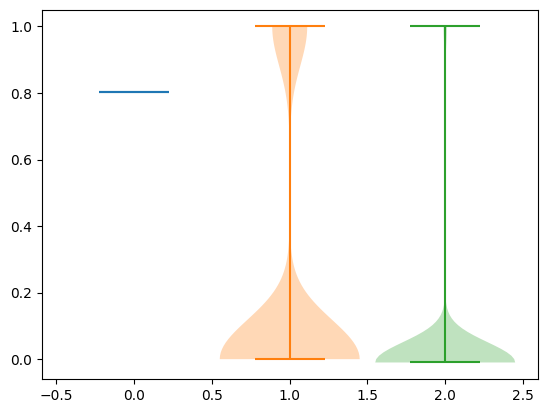

In [22]:
obs_df = pd.DataFrame(data["visual_observation"].reshape(-1))
act_df = pd.DataFrame(data["action"].reshape(-1))
rew_df = pd.DataFrame(data["next", "reward"].reshape(-1))

for i, df in enumerate([obs_df, act_df, rew_df]):
    plt.violinplot(df, positions=[i], widths=0.9)

In [9]:
env.close()
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([9, 1000, 5]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([9, 1000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        indicator: Tensor(shape=torch.Size([9, 1000, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([9, 1000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                indicator: Tensor(shape=torch.Size([9, 1000, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([9, 1000, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([9, 1000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([9, 1000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                visual_observation: Tensor(

## **PPO**

### **Env Config**

In [4]:
env = UnityEnv(ENV_NAME, ENV_PATH, graphics=False)
env_batch_dim = env.batch_dims
action_dim = env.action_spec.shape[env_batch_dim]
# obs_dim = env.observation_spec["observation"].shape[env_batch_dim]
obs_shape = env.observation_spec["visual_observation"].shape[env_batch_dim:]

env.close()

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'discrete_action' is unaccounted for by the transform (expected keys ['RenderTextureSensor', 'VectorlSensor', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


In [5]:
obs_shape
for i in range(5):
    x = 2**i
    print(obs_shape[-2]//x, obs_shape[-1]//x)

64 84
32 42
16 21
8 10
4 5


### **Config**

In [6]:
# PPO
ppo_algo_config = {
    "epsilon": 0.2,
    "entropy_coef": 1e-3,
    "gamma": 0.99,
    "lmbda": 0.95,
}

# Model
# model_config = {
#     "in_features": obs_dim,
#     "out_features": action_dim,
#     "n_blocks": 2,
#     "hidden_dim": 32,
# }
cnn_config = {
    "in_channels": 3,
    "out_dim": 64,
    "time_dim": 2,
    "depths": [1, 1],
    "dims": [16, 32]
}

model_config = {
    "in_features": 64,
    "out_features": action_dim,
    "n_blocks": 1,
    "hidden_dim": 16,
}

# Training
config = PPOTrainConfig(
    generations=100,
    generation_size=10_000,
    slice_len=128,
    n_slices=32,
    epochs=3,
    minibatch_size=256,

    workers=8,
    env_batch_dim=env_batch_dim,

    kl_soft_clip=0.02,
    early_stop_threshold=8,
    kl_hard_clip=0.05,

    start_generation=0,
)
LR = 5e-4

cnn_config, model_config

({'in_channels': 3,
  'out_dim': 64,
  'time_dim': 2,
  'depths': [1, 1],
  'dims': [16, 32]},
 {'in_features': 64, 'out_features': 5, 'n_blocks': 1, 'hidden_dim': 16})

In [7]:
cnn_model = ConditionalCNN(**cnn_config)
summary(cnn_model, input_size=[(1, *obs_shape), (1, 2)])

Layer (type:depth-idx)                   Output Shape              Param #
ConditionalCNN                           [1, 64]                   --
├─Sequential: 1-1                        [1, 16, 16, 21]           --
│    └─Conv2d: 2-1                       [1, 16, 16, 21]           784
│    └─LayerNorm2d: 2-2                  [1, 16, 16, 21]           32
├─Sequential: 1-2                        [1, 32]                   --
│    └─Linear: 2-3                       [1, 32]                   64
│    └─MLPBlock: 2-4                     [1, 32]                   --
│    │    └─RMSNorm: 3-1                 [1, 32]                   32
│    │    └─GatedLinear: 3-2             [1, 85]                   5,440
│    │    └─Linear: 3-3                  [1, 32]                   2,720
├─ModuleList: 1-5                        --                        (recursive)
│    └─ModuleList: 2-5                   --                        --
│    │    └─CondCXBlock: 3-4             [1, 16, 16, 21]           4,

### **State**

In [8]:
action_type = 'discrete'
in_keys = ['visual_observation', 'indicator']

# Policy
policy_config = model_config.copy()
if action_type == 'continuous':
    policy_config["out_features"] *= 2      
# policy_base = MLP(**policy_config)
policy_base = CondVisionFeatureModel(cnn_model, MLP(**policy_config))
policy = PolicyWrapper(policy_base, policy_type=action_type, in_keys=in_keys)

# Value
value_config = model_config.copy()
value_config["out_features"] = 1
# value_base = MLP(**value_config)
value_base = CondVisionFeatureModel(cnn_model, MLP(**value_config))
value = ValueWrapper(value_base, in_keys=in_keys)

# Loss Module
loss_module = PPOLossModule(policy, value, **ppo_algo_config)

# Optimizer
optimizer = optim.Adam(loss_module.parameters(), lr=LR)

# Logger
logger = TensorBoardLogger(ppo_log_keys, log_dir='temp/logs') # LoggerBase(ppo_log_keys)
logger.reset()

# State
state = PPOState(
    policy=policy,
    value=value,
    optimizer=optimizer,
    loss_module=loss_module,

    logger=logger,
)

In [9]:
summary(policy_base, input_size=[(1, *obs_shape), (1, 2)], depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
CondVisionFeatureModel                        [1, 5]                    --
├─ConditionalCNN: 1-1                         [1, 64]                   20,384
│    └─Sequential: 2-1                        [1, 16, 16, 21]           --
│    │    └─Conv2d: 3-1                       [1, 16, 16, 21]           784
│    │    └─LayerNorm2d: 3-2                  [1, 16, 16, 21]           32
│    └─Sequential: 2-2                        [1, 32]                   --
│    │    └─Linear: 3-3                       [1, 32]                   64
│    │    └─MLPBlock: 3-4                     [1, 32]                   8,192
├─MLP: 1-2                                    --                        (recursive)
│    └─ModuleList: 2-11                       --                        (recursive)
│    │    └─MLPBlock: 3-5                     --                        (recursive)
├─ConditionalCNN: 1-3                         --            

### **PPO**

In [10]:
ppo = PPOBasic(lambda: UnityEnv(ENV_NAME, ENV_PATH, graphics=True), ppo_config=config, ppo_state=state)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-typetree-allocator-block-size=2097152"
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-bucket-allocator-granularity=16"
 

In [11]:
ppo.run(verbose=True)

[1/100] Starting Generation
[1/100] Collected Data in 9.705620765686035
2025-12-14 02:11:11,303 [torchrl][WARNING]    Got a tensordict without a time-marked dimension, assuming time is along the last dimension. This warning can be turned off by setting the environment variable RL_WARNINGS to False. [END]


/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


2025-12-14 02:11:11,821 [torchrl][WARNING]    Got a tensordict without a time-marked dimension, assuming time is along the last dimension. This warning can be turned off by setting the environment variable RL_WARNINGS to False. [END]
2025-12-14 02:11:12,221 [torchrl][WARNING]    Got a tensordict without a time-marked dimension, assuming time is along the last dimension. This warning can be turned off by setting the environment variable RL_WARNINGS to False. [END]
2025-12-14 02:11:12,633 [torchrl][WARNING]    Got a tensordict without a time-marked dimension, assuming time is along the last dimension. This warning can be turned off by setting the environment variable RL_WARNINGS to False. [END]
2025-12-14 02:11:12,946 [torchrl][WARNING]    Got a tensordict without a time-marked dimension, assuming time is along the last dimension. This warning can be turned off by setting the environment variable RL_WARNINGS to False. [END]
2025-12-14 02:11:13,307 [torchrl][WARNING]    Got a tensordict w

Process _ProcessNoWarn-7:
Process _ProcessNoWarn-3:
Process _ProcessNoWarn-4:
Process _ProcessNoWarn-1:
Process _ProcessNoWarn-5:
Process _ProcessNoWarn-6:
Process _ProcessNoWarn-2:
Process _ProcessNoWarn-8:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torchrl/_utils.py", line 594, in run
    return mp.Process.run(self, *args, **kwargs)
  File "/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torchrl/collectors/collectors.py", line 3634, in _main_async_collector
    if not run_free and pipe_child.poll(_timeout):
  File "/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/multiprocessing/conne

KeyboardInterrupt: 

In [11]:
ppo.close()

### **Plot Results**

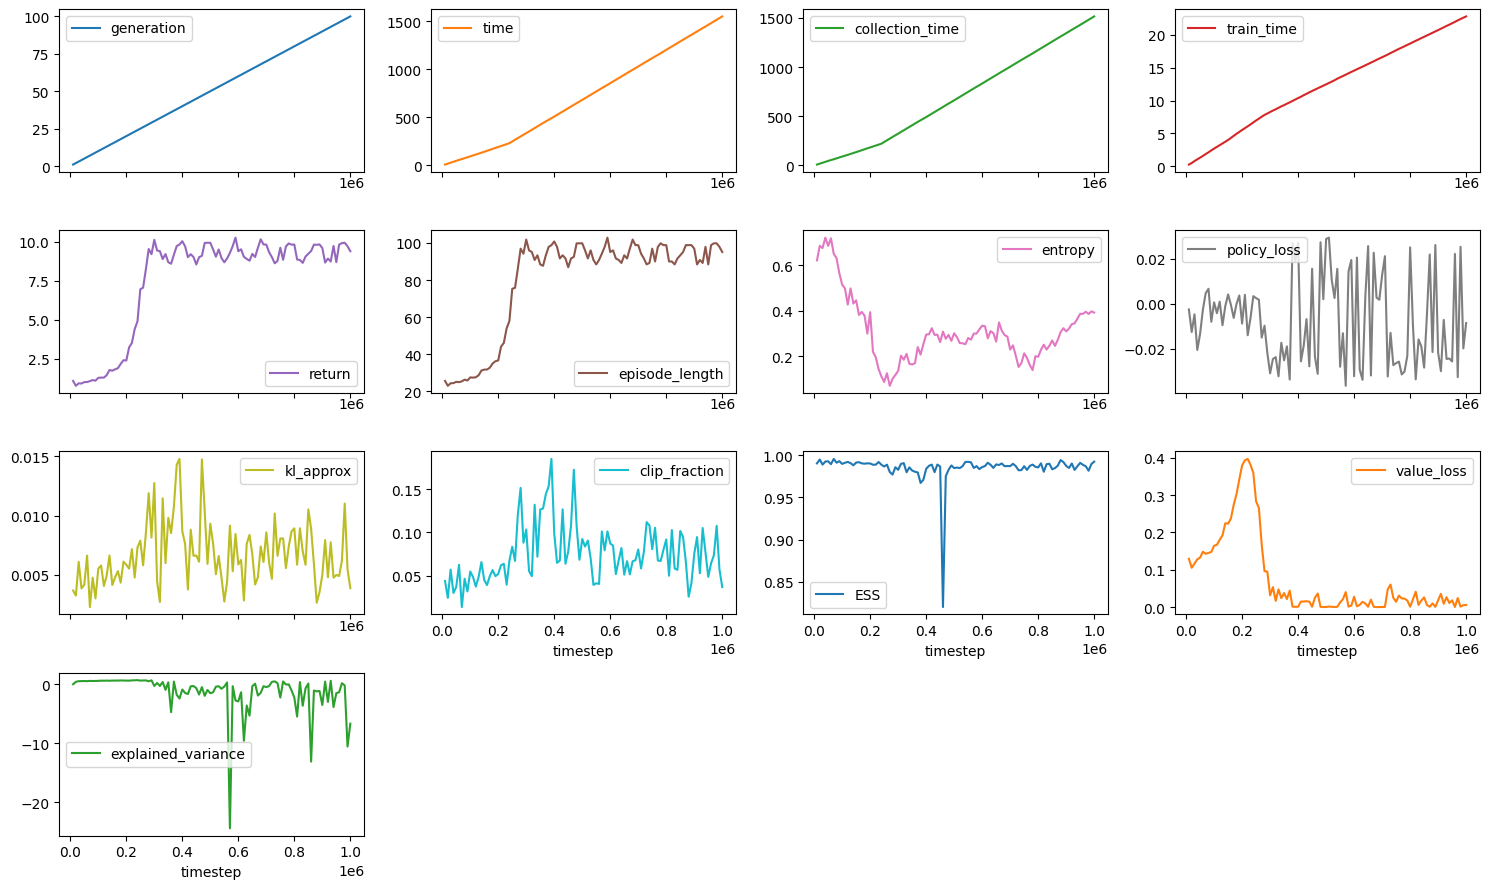

In [14]:
LOG_INDEX = "timestep"
def plot():
    df = logger.dataframe()
    df = df.set_index(LOG_INDEX)

    rows = (len(df.columns) + 3) // 4
    df.plot(subplots=True, layout=(rows,4), figsize=(15, int(rows* 7/3)))
    plt.tight_layout()
    plt.show()
plot()

## **Evaluate Agent**

In [31]:
ENV_NAME='PushBlock'

In [32]:
directory_path = os.path.join("experiments", ENV_NAME, "ppo", "conf1")
load_type = 'models'
model_path = os.path.join(directory_path, load_type)
names = os.listdir(model_path)
names

['run1.pt']

In [33]:
run_name = 'run1'
run = [name for name in names if name.startswith(run_name)][0]
run

'run1.pt'

In [34]:
from hydra.utils import get_class, instantiate
from omegaconf import DictConfig, OmegaConf

todict = lambda x: OmegaConf.to_container(x, resolve=True)

config_path = os.path.join(directory_path, 'config/config.yaml')
config = OmegaConf.load(config_path)

log_keys = list(config.logger.get("keys", ppo_log_keys))
if "lr_scheduler" in config: log_keys.append("lr")
logger = instantiate(config.logger, keys=log_keys)
logger.revert()

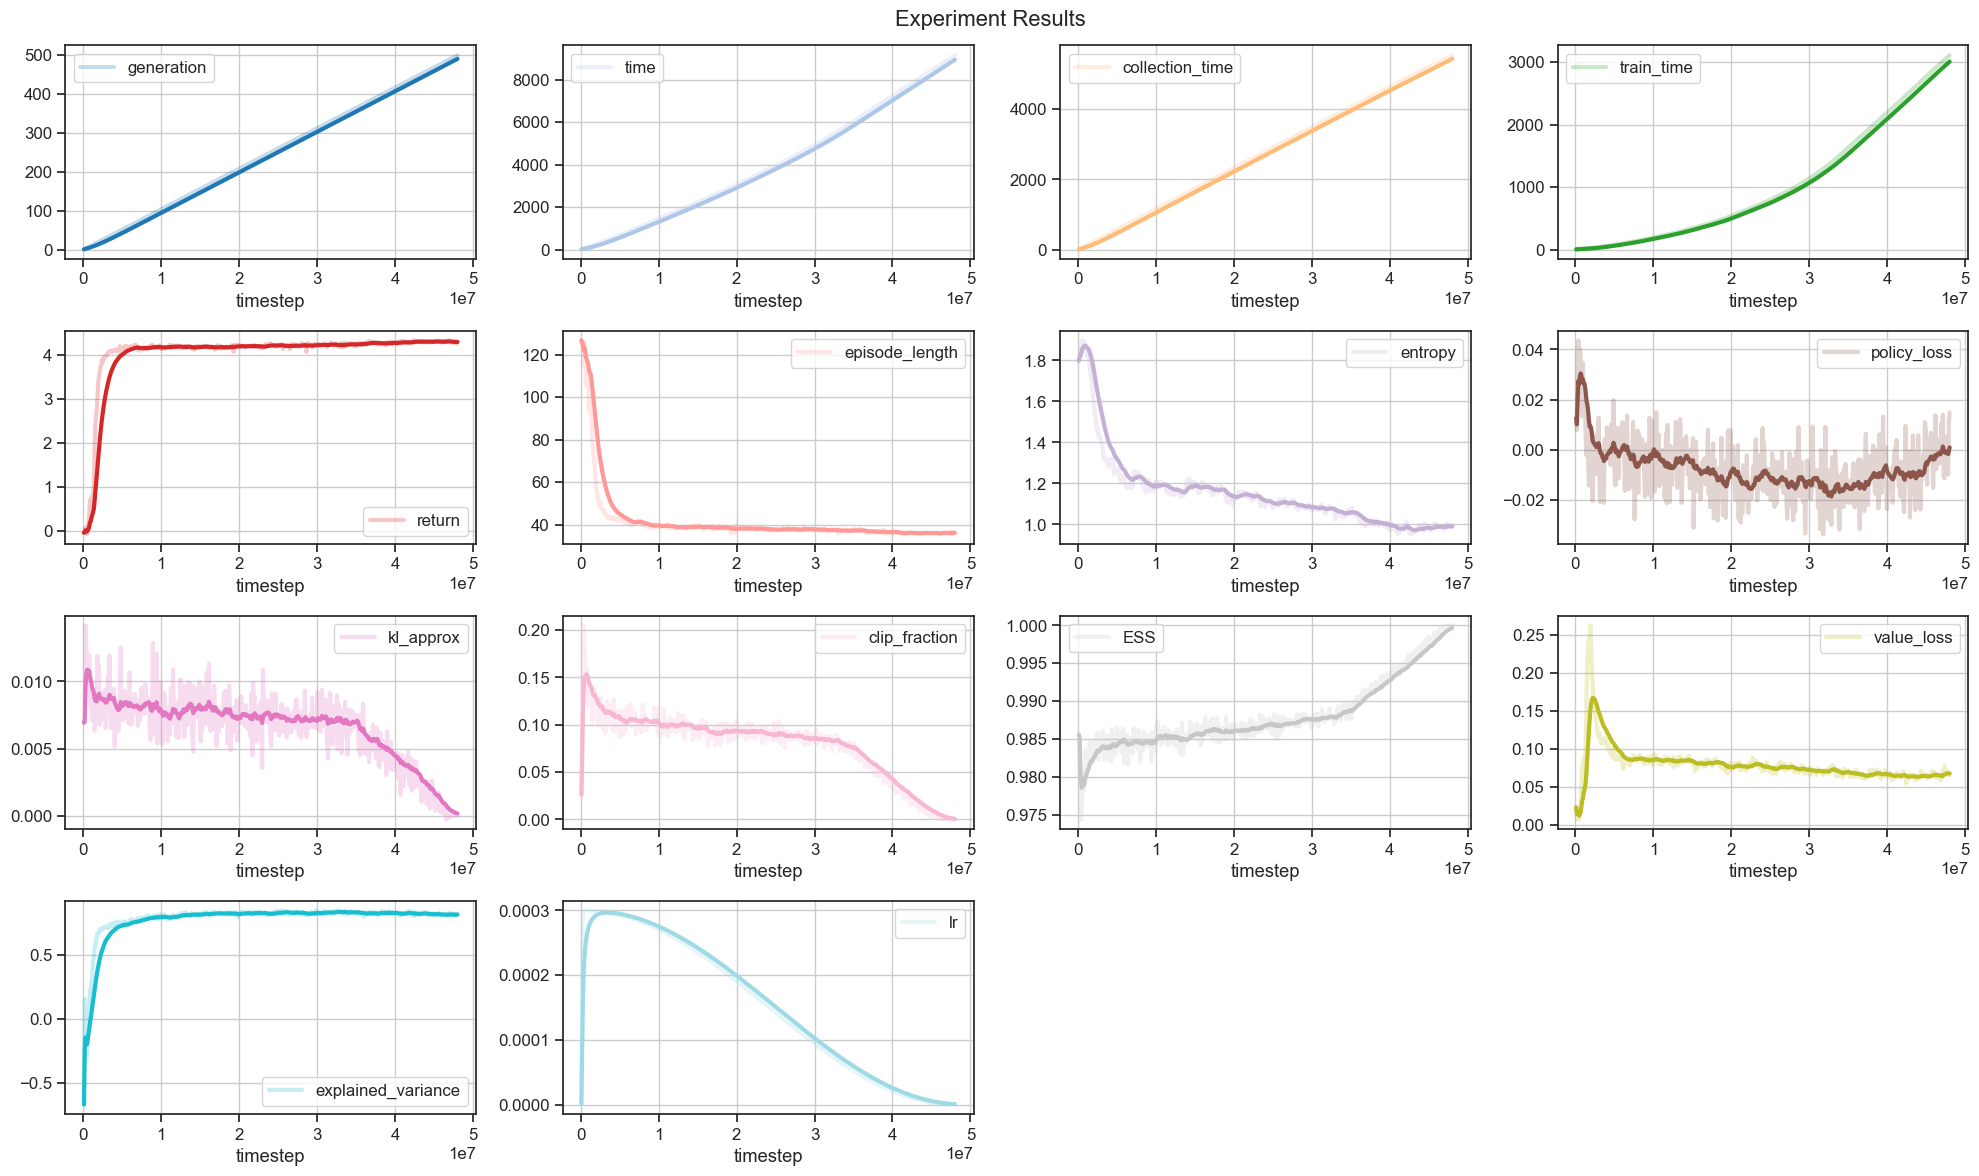

In [36]:
results_path = None #os.path.join(directory_path, 'results', f'{run_name}.png')
plot_results(logger, log_index='timestep', ewma_span=20, path=results_path)

In [21]:
save_name = os.path.join(load_type, run)
print("Using:", os.path.join(directory_path, save_name))
policy, _ = ppo_load_config(directory_path, save_name=save_name, weights_only=False)

Using: experiments/Crawler/ppo/conf1/models/run9.pt


In [22]:
try: env.close()
except: pass

env = UnityEnv(name=ENV_NAME, path=ENV_PATH, graphics=True, time_scale=1, seed=1)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'continuous_action' is unaccounted for by the transform (expected keys ['PhysicsBodySensor:Body', 'VectorSensor_size32', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


In [31]:
env.rollout(1000, break_when_any_done=False)

KeyboardInterrupt: 

In [23]:
data = None
with torch.no_grad():
    data = env.rollout(1000, policy=policy, break_when_any_done=False)

In [8]:
try: env.close()
except: pass

SimpleMetricModule(mode="approx")(data)

{'return': 375.8510437011719,
 'episode_length': 1000.0,
 'entropy': 6.023764133453369}

In [9]:
from mlagents_envs.registry import default_registry

environment_names = list(default_registry.keys())

AttributeError: can't set attribute 'reason'